In [1]:
import pandas as pd
from pandas_profiling import ProfileReport
import numpy as np

import matplotlib as m
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pylab import rcParams 

from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional
from keras.preprocessing.sequence import TimeseriesGenerator
from keras import optimizers


Using TensorFlow backend.


Dataset https://community.tableau.com/docs/DOC-1236

In [2]:
data = pd.read_excel('SampleSuperstore.xls')

### Verificando o tamanho do dataset e se possui valores missing 

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Row ID         9994 non-null   int64         
 1   Order ID       9994 non-null   object        
 2   Order Date     9994 non-null   datetime64[ns]
 3   Ship Date      9994 non-null   datetime64[ns]
 4   Ship Mode      9994 non-null   object        
 5   Customer ID    9994 non-null   object        
 6   Customer Name  9994 non-null   object        
 7   Segment        9994 non-null   object        
 8   Country        9994 non-null   object        
 9   City           9994 non-null   object        
 10  State          9994 non-null   object        
 11  Postal Code    9994 non-null   int64         
 12  Region         9994 non-null   object        
 13  Product ID     9994 non-null   object        
 14  Category       9994 non-null   object        
 15  Sub-Category   9994 n

### Checando a distribuição do dados

In [4]:
data.describe()

,Row ID,Postal Code,Sales,Quantity,Discount,Profit
count,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000
mean,4997.500000,55190.379428,229.858001,3.789574,0.156203,28.656896
std,2885.163629,32063.693350,623.245101,2.225110,0.206452,234.260108
min,1.000000,1040.000000,0.444000,1.000000,0.000000,-6599.978000
25%,2499.250000,23223.000000,17.280000,2.000000,0.000000,1.728750
50%,4997.500000,56430.500000,54.490000,3.000000,0.200000,8.666500
75%,7495.750000,90008.000000,209.940000,5.000000,0.200000,29.364000
max,9994.000000,99301.000000,22638.480000,14.000000,0.800000,8399.976000


### Modificando o nome das colunas 

In [5]:
data.columns = map(str.lower, data.columns)
data.columns = data.columns.str.replace(' ','_')
data.columns = data.columns.str.replace('-','_')
data.columns

Index(['row_id', 'order_id', 'order_date', 'ship_date', 'ship_mode',
       'customer_id', 'customer_name', 'segment', 'country', 'city', 'state',
       'postal_code', 'region', 'product_id', 'category', 'sub_category',
       'product_name', 'sales', 'quantity', 'discount', 'profit'],
      dtype='object')

### Verificando as categorias 

In [6]:
data.category.drop_duplicates()

0          Furniture
2    Office Supplies
7         Technology
Name: category, dtype: object

### Separa os dados em 3 categorias

In [7]:
df_moveis = data.loc[data['category'] == 'Furniture']
df_office = data.loc[data['category'] == 'Office Supplies']
df_tecnologia = data.loc[data['category'] == 'Technology']

### Resumindo os dados pela soma das vendas por dia

In [8]:
moveis_diario = df_moveis.groupby('order_date')['sales'].sum().reset_index()
office_diario = df_office.groupby('order_date')['sales'].sum().reset_index()
tecnologia_diario = df_tecnologia.groupby('order_date')['sales'].sum().reset_index()

In [9]:
moveis_diario

,order_date,sales
0,2014-01-06,2573.8200
1,2014-01-07,76.7280
2,2014-01-10,51.9400
3,2014-01-11,9.9400
4,2014-01-13,879.9390
...,...,...
884,2017-12-24,1393.4940
885,2017-12-25,832.4540
886,2017-12-28,551.2568
887,2017-12-29,2330.7180


### Definindo a data como index

In [10]:
moveis_diario = moveis_diario.set_index('order_date')
office_diario = office_diario.set_index('order_date')
tecnologia_diario = tecnologia_diario.set_index('order_date')

In [11]:
tecnologia_diario

,sales
order_date,
2014-01-06,1147.940
2014-01-09,31.200
2014-01-13,646.740
2014-01-15,149.950
2014-01-16,124.200
...,...
2017-12-25,401.208
2017-12-27,164.388
2017-12-28,14.850


###  Verificando as vendas

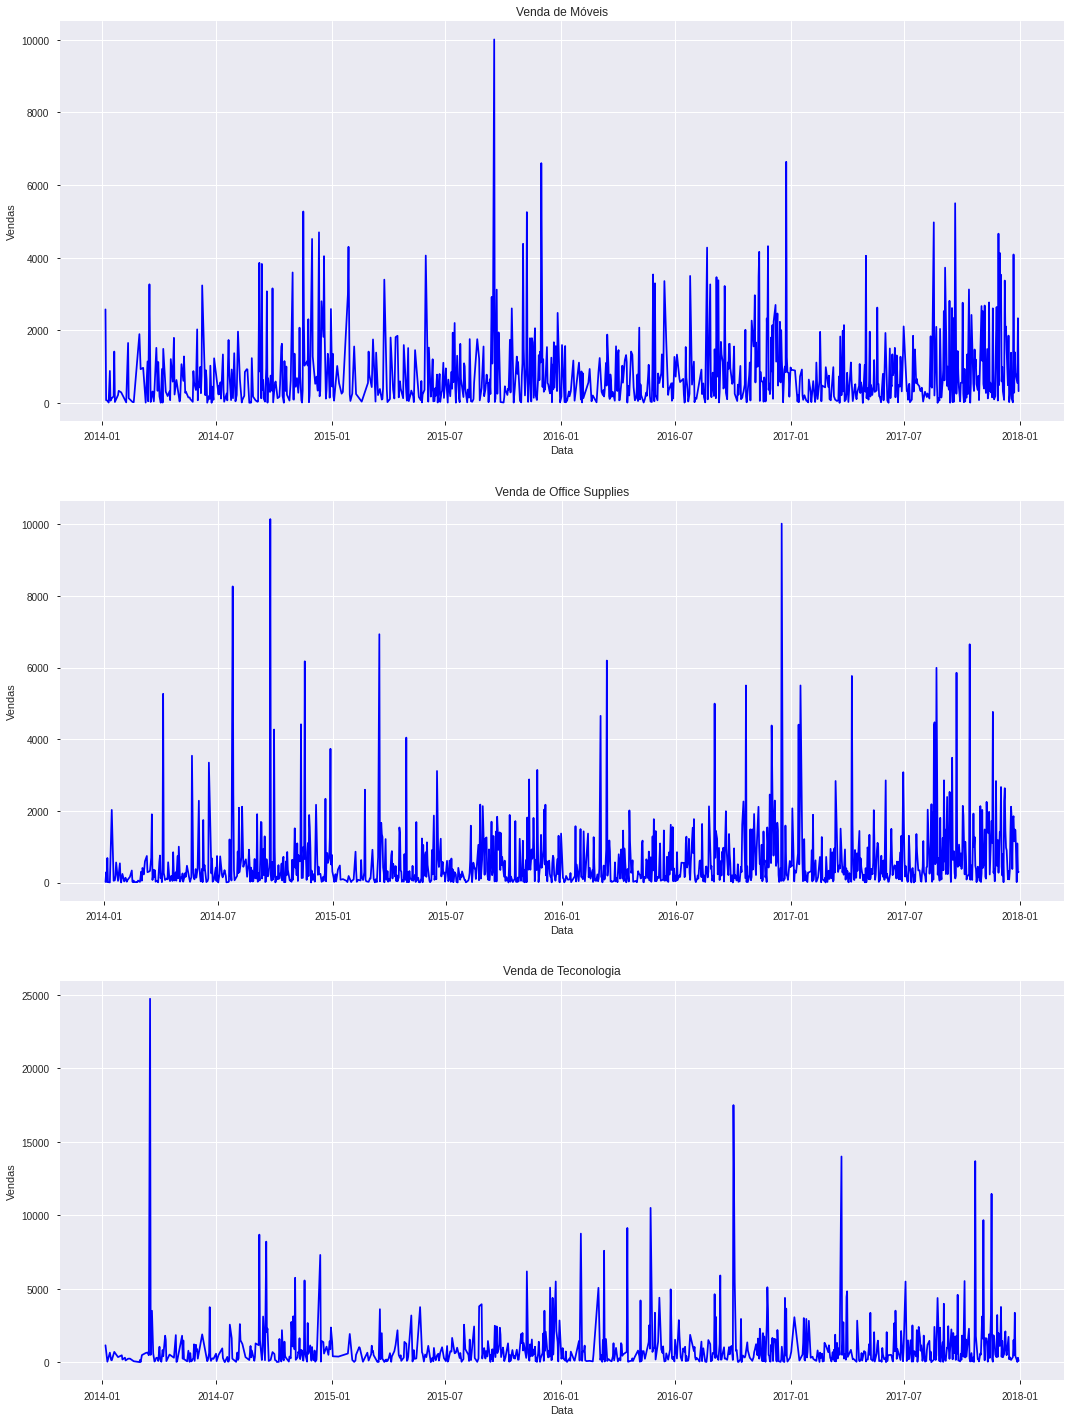

In [12]:
fig, axes = plt.subplots(3, figsize=(18,25))
axes[0].plot(moveis_diario.sales, color='b')
axes[0].set_xlabel('Data')
axes[0].set_ylabel('Vendas')
axes[0].set_title('Venda de Móveis')
axes[0].grid(True)

axes[1].plot(office_diario.sales, color='b')
axes[1].set_xlabel('Data')
axes[1].set_ylabel('Vendas')
axes[1].set_title('Venda de Office Supplies')
axes[1].grid(True)

axes[2].plot(tecnologia_diario.sales, color='b')
axes[2].set_xlabel('Data')
axes[2].set_ylabel('Vendas')
axes[2].set_title('Venda de Teconologia')
axes[2].grid(True)

### Removendo as maiores vendas

In [13]:
vendas_moveis = moveis_diario[moveis_diario.sales < 6000]
vendas_office = office_diario[office_diario.sales < 6000]
vendas_tecnologia = tecnologia_diario[tecnologia_diario.sales < 12500]

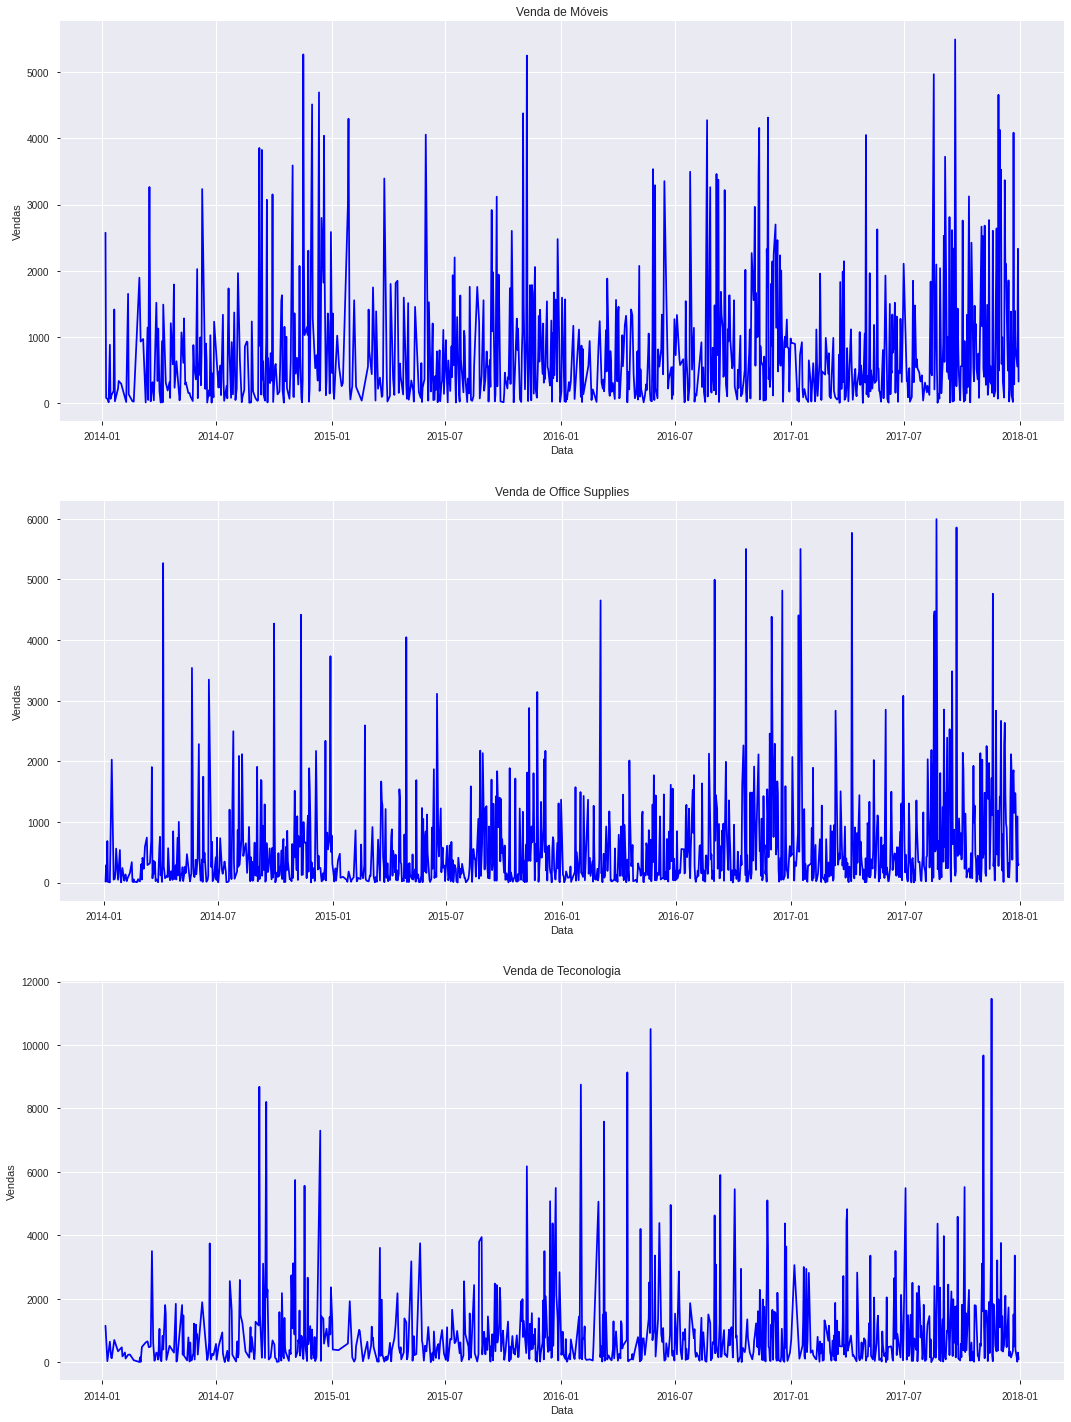

In [14]:
fig, axes = plt.subplots(3, figsize=(18,25))
axes[0].plot(vendas_moveis.sales, color='b')
axes[0].set_xlabel('Data')
axes[0].set_ylabel('Vendas')
axes[0].set_title('Venda de Móveis')
axes[0].grid(True)

axes[1].plot(vendas_office.sales, color='b')
axes[1].set_xlabel('Data')
axes[1].set_ylabel('Vendas')
axes[1].set_title('Venda de Office Supplies')
axes[1].grid(True)

axes[2].plot(vendas_tecnologia.sales, color='b')
axes[2].set_xlabel('Data')
axes[2].set_ylabel('Vendas')
axes[2].set_title('Venda de Teconologia')
axes[2].grid(True)

### Agrupando os dados por mês

In [15]:
moveis_vendas_mes = vendas_moveis['sales'].resample('MS').mean()
office_vendas_mes = vendas_office['sales'].resample('MS').mean()
tecnologia_vendas_mes = vendas_tecnologia['sales'].resample('MS').mean()

### Venda de Móveis
O gráfico mostra que tendência está em alta e a sazonalidade mostra que o período de maior volume de vendas está no mês de Novembro e Dezembro enquanto o menor volume de venda está em Fevereiro.

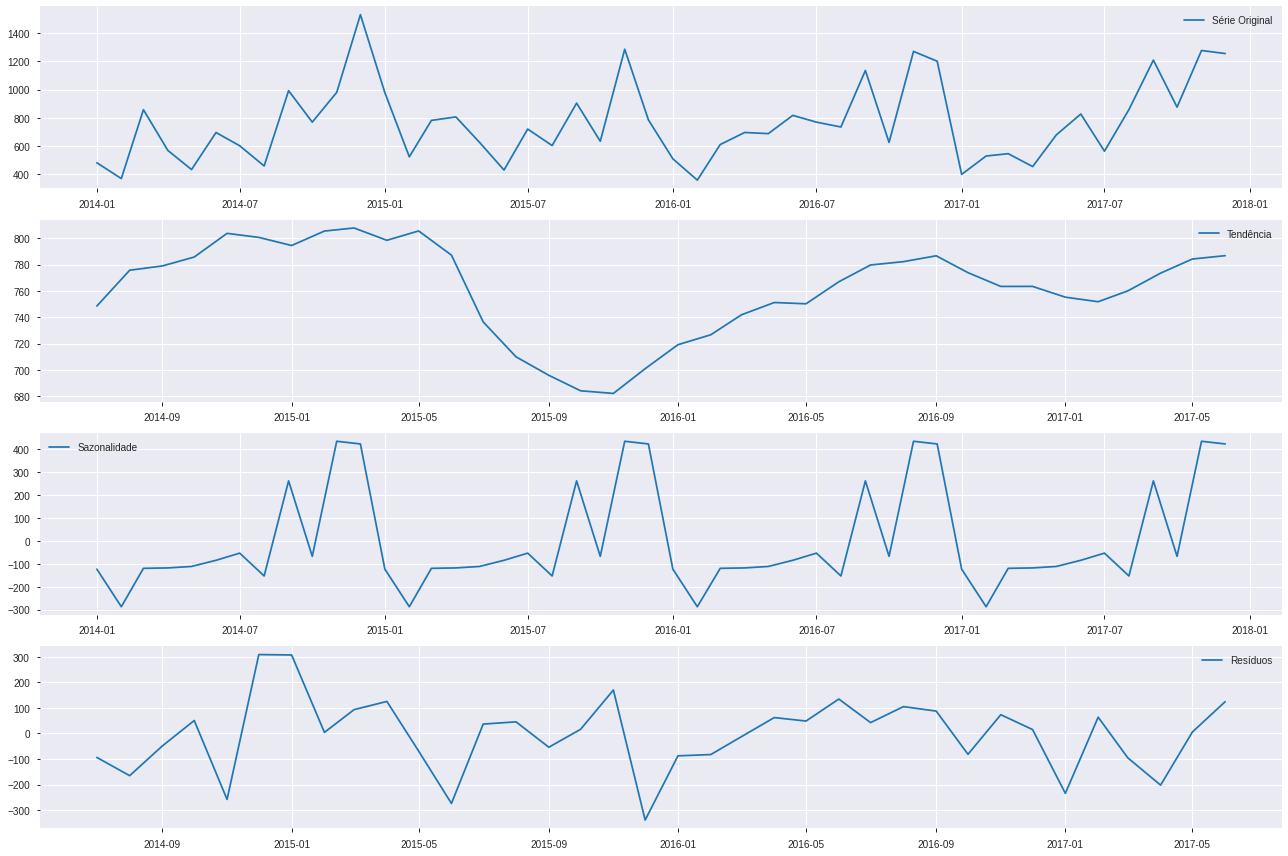

In [16]:
decomposicao = seasonal_decompose(moveis_vendas_mes, period=12)
rcParams['figure.figsize'] = 18,12

# Componentes
trend = decomposicao.trend
seasonal = decomposicao.seasonal
residual = decomposicao.resid

plt.subplot(411)
plt.plot(moveis_vendas_mes, label='Série Original')
plt.legend(loc = 'best')
plt.subplot(412)
plt.plot(trend, label = 'Tendência')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal, label = 'Sazonalidade')
plt.legend(loc = 'best')
plt.subplot(414)
plt.plot(residual, label = 'Resíduos')
plt.legend(loc = 'best')
plt.tight_layout()

### Venda de Office Supplies
A tendêndia mostra um crescimento constate desde do ano de 2016 e a sazonalidade mostra que os meses com maior venda são Setembro, Novembro e Dezembro e com menor venda no mês de Fevereiro.

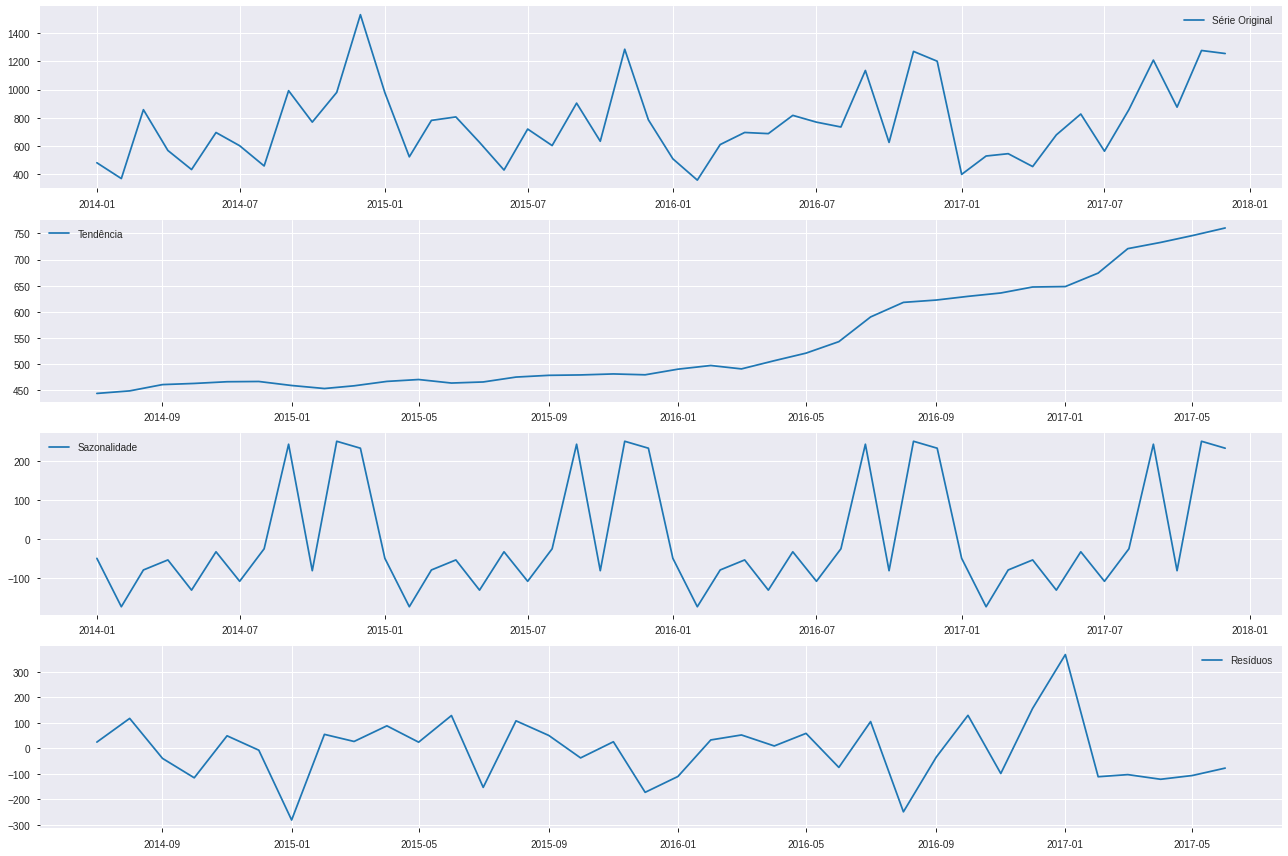

In [17]:
decomposicao = seasonal_decompose(office_vendas_mes, period=12)
rcParams['figure.figsize'] = 18,12

# Componentes
trend = decomposicao.trend
seasonal = decomposicao.seasonal
residual = decomposicao.resid

plt.subplot(411)
plt.plot(moveis_vendas_mes, label='Série Original')
plt.legend(loc = 'best')
plt.subplot(412)
plt.plot(trend, label = 'Tendência')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal, label = 'Sazonalidade')
plt.legend(loc = 'best')
plt.subplot(414)
plt.plot(residual, label = 'Resíduos')
plt.legend(loc = 'best')
plt.tight_layout()

### Venda de Tecnologia
A tendêndia mostra que está em auta, e a sazonalidade mostra que os meses com maior venda são Setembro, Novembro e Dezembro e com menor venda no mês de Fevereiro.

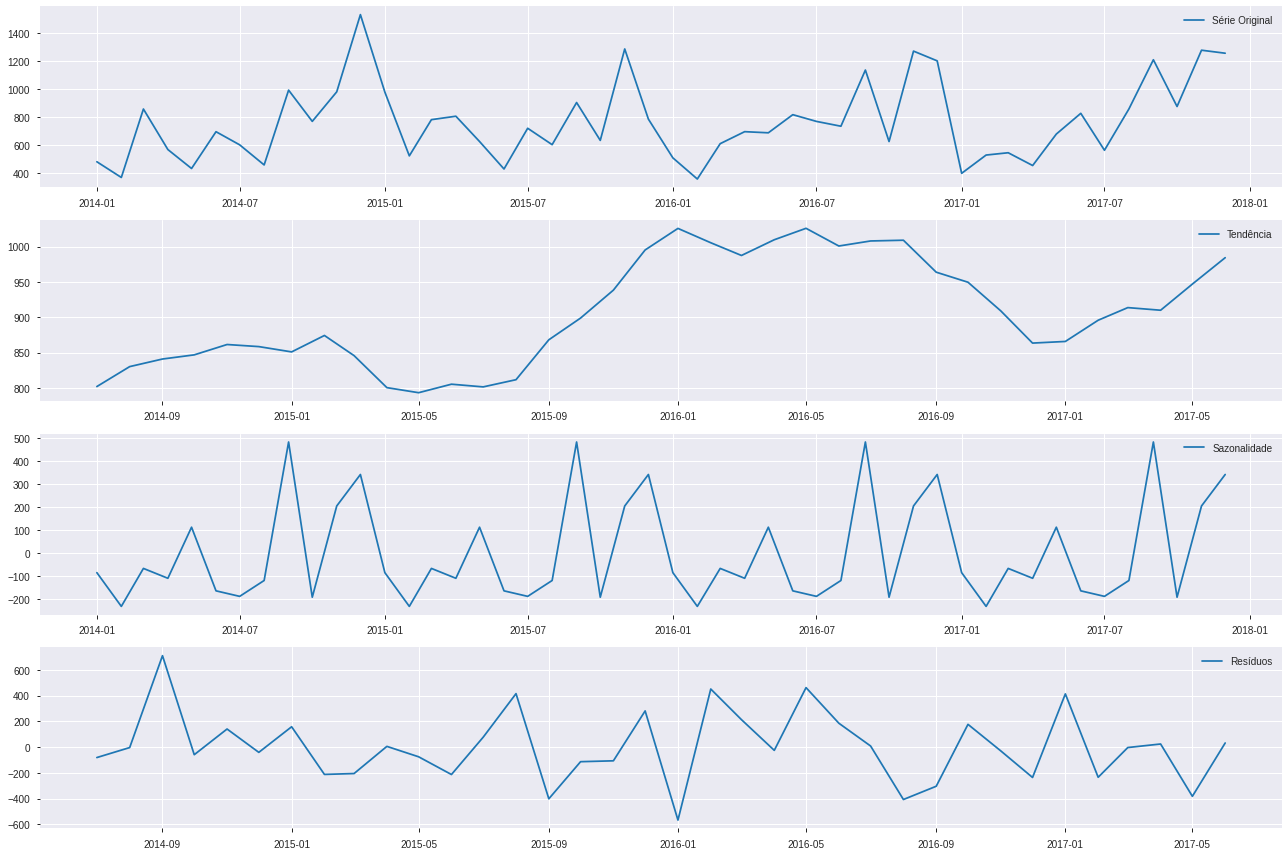

In [18]:
decomposicao = seasonal_decompose(tecnologia_vendas_mes, period=12)
rcParams['figure.figsize'] = 18,12

# Componentes
trend = decomposicao.trend
seasonal = decomposicao.seasonal
residual = decomposicao.resid

plt.subplot(411)
plt.plot(moveis_vendas_mes, label='Série Original')
plt.legend(loc = 'best')
plt.subplot(412)
plt.plot(trend, label = 'Tendência')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal, label = 'Sazonalidade')
plt.legend(loc = 'best')
plt.subplot(414)
plt.plot(residual, label = 'Resíduos')
plt.legend(loc = 'best')
plt.tight_layout()

### Preparando os dados para o treinamento

In [19]:
x_moveis = moveis_vendas_mes

In [20]:
x_moveis[:-12]

order_date
2014-01-01     480.194231
2014-02-01     367.931600
2014-03-01     857.291529
2014-04-01     567.488357
2014-05-01     432.049187
2014-06-01     695.059242
2014-07-01     601.169500
2014-08-01     457.521656
2014-09-01     992.353367
2014-10-01     769.015437
2014-11-01     980.221486
2014-12-01    1532.298325
2015-01-01     978.328467
2015-02-01     522.395667
2015-03-01     781.236437
2015-04-01     805.822962
2015-05-01     624.996700
2015-06-01     428.565500
2015-07-01     719.706316
2015-08-01     602.412012
2015-09-01     903.713833
2015-10-01     632.980184
2015-11-01    1286.701354
2015-12-01     785.006629
2016-01-01     508.182867
2016-02-01     356.868273
2016-03-01     609.575810
2016-04-01     695.373158
2016-05-01     687.265227
2016-06-01     816.910750
2016-07-01     768.736412
2016-08-01     734.307782
2016-09-01    1135.953371
2016-10-01     624.872474
2016-11-01    1271.345152
2016-12-01    1201.674080
Freq: MS, Name: sales, dtype: float64

In [21]:
x_moveis[-12:]

order_date
2017-01-01     397.602133
2017-02-01     528.179800
2017-03-01     544.672240
2017-04-01     453.297905
2017-05-01     678.302328
2017-06-01     826.460291
2017-07-01     562.524857
2017-08-01     857.881889
2017-09-01    1209.508583
2017-10-01     875.362728
2017-11-01    1277.817759
2017-12-01    1256.298672
Freq: MS, Name: sales, dtype: float64

In [22]:
treino_moveis, teste_moveis = np.array(x_moveis[:-12]), np.array(x_moveis[-12:])

In [23]:
treino_moveis = treino_moveis.reshape(-1,1)
teste_moveis = teste_moveis.reshape(-1,1)

In [24]:
print(len(treino_moveis))
treino_moveis

36


array([[ 480.19423077],
       [ 367.9316    ],
       [ 857.29152941],
       [ 567.48835714],
       [ 432.0491875 ],
       [ 695.05924211],
       [ 601.1695    ],
       [ 457.52165625],
       [ 992.35336667],
       [ 769.0154375 ],
       [ 980.22148636],
       [1532.298325  ],
       [ 978.32846667],
       [ 522.39566667],
       [ 781.2364375 ],
       [ 805.82296154],
       [ 624.9967    ],
       [ 428.5655    ],
       [ 719.70631579],
       [ 602.4120125 ],
       [ 903.71383333],
       [ 632.98018421],
       [1286.70135417],
       [ 785.00662857],
       [ 508.18286667],
       [ 356.86827273],
       [ 609.57580952],
       [ 695.37315789],
       [ 687.26522727],
       [ 816.91075   ],
       [ 768.73641176],
       [ 734.30778235],
       [1135.95337083],
       [ 624.87247368],
       [1271.345152  ],
       [1201.67408   ]])

In [25]:
print(len(teste_moveis))
teste_moveis

12


array([[ 397.60213333],
       [ 528.1798    ],
       [ 544.67224   ],
       [ 453.297905  ],
       [ 678.302328  ],
       [ 826.4602913 ],
       [ 562.52485714],
       [ 857.88188889],
       [1209.50858333],
       [ 875.362728  ],
       [1277.81775862],
       [1256.298672  ]])

In [26]:
scaler = MinMaxScaler()
scaler.fit(treino_moveis)
treino_moveis = scaler.transform(treino_moveis)

In [27]:
treino_moveis.shape

(36, 1)

### Definindo os hiperparâmetros

In [28]:
epochs = 200
entrada = 12
saida = 12
features = 1
batch = 10
repete = 10

In [29]:
generator = TimeseriesGenerator(treino_moveis, treino_moveis, length=saida, batch_size=batch)

### Definindo o modelo

In [30]:
# Criamos uma matriz preenchida com zeros que receberá o resultado das previsões do nosso modelo
resultado = np.zeros((entrada, repete))

for i in range(repete):
    model = Sequential()
    model.add(Bidirectional(LSTM(24, activation = 'relu'), input_shape = (12, 1)))
    model.add(Dense(1))
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')
    model.fit_generator(generator, epochs = epochs)
    
    # Lista para as previsões
    previsto = []

    # Gera um batch de dados
    batch = treino_moveis[-entrada:].reshape((1, entrada, features))

    # Loop para fazer as previsões
    for j in range(entrada):   
        previsto.append(model.predict(batch)[0]) 
        batch = np.append(batch[:,1:,:], [[previsto[j]]], axis = 1)

    # Gera o dataframe com as previsões
    dados_moveis = pd.DataFrame(scaler.inverse_transform(previsto),
                                      index = x_moveis[-entrada:].index, columns = ['Previsão'])

    resultado[:,i] = dados_moveis['Previsão']
    
print(resultado)

Epoch 1/200
3/3 [==============================] - 1s 195ms/step - loss: 0.2225
Epoch 2/200
3/3 [==============================] - 0s 10ms/step - loss: 0.2043
Epoch 3/200
3/3 [==============================] - 0s 26ms/step - loss: 0.1840
Epoch 4/200
3/3 [==============================] - 0s 10ms/step - loss: 0.1656
Epoch 5/200
3/3 [==============================] - 0s 32ms/step - loss: 0.1507
Epoch 6/200
3/3 [==============================] - 0s 18ms/step - loss: 0.1334
Epoch 7/200
3/3 [==============================] - 0s 38ms/step - loss: 0.1184
Epoch 8/200
3/3 [==============================] - 0s 12ms/step - loss: 0.1048
Epoch 9/200
3/3 [==============================] - 0s 29ms/step - loss: 0.0937
Epoch 10/200
3/3 [==============================] - 0s 23ms/step - loss: 0.0814
Epoch 11/200
3/3 [==============================] - 0s 23ms/step - loss: 0.0701
Epoch 12/200
3/3 [==============================] - 0s 28ms/step - loss: 0.0639
Epoch 13/200
3/3 [==============================

3/3 [==============================] - 0s 32ms/step - loss: 0.1855
Epoch 5/200
3/3 [==============================] - 0s 16ms/step - loss: 0.1684
Epoch 6/200
3/3 [==============================] - 0s 26ms/step - loss: 0.1510
Epoch 7/200
3/3 [==============================] - 0s 25ms/step - loss: 0.1388
Epoch 8/200
3/3 [==============================] - 0s 24ms/step - loss: 0.1256
Epoch 9/200
3/3 [==============================] - 0s 27ms/step - loss: 0.1120
Epoch 10/200
3/3 [==============================] - 0s 25ms/step - loss: 0.1013
Epoch 11/200
3/3 [==============================] - 0s 11ms/step - loss: 0.0892
Epoch 12/200
3/3 [==============================] - 0s 31ms/step - loss: 0.0811
Epoch 13/200
3/3 [==============================] - 0s 12ms/step - loss: 0.0730
Epoch 14/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0641
Epoch 15/200
3/3 [==============================] - 0s 18ms/step - loss: 0.0611
Epoch 16/200
3/3 [==============================] - 0s 29m

3/3 [==============================] - 0s 10ms/step - loss: 0.0719
Epoch 8/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0654
Epoch 9/200
3/3 [==============================] - 0s 11ms/step - loss: 0.0597
Epoch 10/200
3/3 [==============================] - 0s 37ms/step - loss: 0.0523
Epoch 11/200
3/3 [==============================] - 0s 20ms/step - loss: 0.0545
Epoch 12/200
3/3 [==============================] - 0s 13ms/step - loss: 0.0550
Epoch 13/200
3/3 [==============================] - 0s 29ms/step - loss: 0.0552
Epoch 14/200
3/3 [==============================] - 0s 10ms/step - loss: 0.0548
Epoch 15/200
3/3 [==============================] - 0s 26ms/step - loss: 0.0548
Epoch 16/200
3/3 [==============================] - 0s 14ms/step - loss: 0.0544
Epoch 17/200
3/3 [==============================] - 0s 25ms/step - loss: 0.0533
Epoch 18/200
3/3 [==============================] - 0s 26ms/step - loss: 0.0534
Epoch 19/200
3/3 [==============================] - 0s 

3/3 [==============================] - 0s 12ms/step - loss: 0.0840
Epoch 11/200
3/3 [==============================] - 0s 30ms/step - loss: 0.0780
Epoch 12/200
3/3 [==============================] - 0s 11ms/step - loss: 0.0686
Epoch 13/200
3/3 [==============================] - 0s 30ms/step - loss: 0.0603
Epoch 14/200
3/3 [==============================] - 0s 10ms/step - loss: 0.0574
Epoch 15/200
3/3 [==============================] - 0s 30ms/step - loss: 0.0536
Epoch 16/200
3/3 [==============================] - 0s 11ms/step - loss: 0.0552
Epoch 17/200
3/3 [==============================] - 0s 31ms/step - loss: 0.0532
Epoch 18/200
3/3 [==============================] - 0s 16ms/step - loss: 0.0557
Epoch 19/200
3/3 [==============================] - 0s 32ms/step - loss: 0.0557
Epoch 20/200
3/3 [==============================] - 0s 21ms/step - loss: 0.0554
Epoch 21/200
3/3 [==============================] - 0s 29ms/step - loss: 0.0555
Epoch 22/200
3/3 [==============================] - 0

3/3 [==============================] - 0s 32ms/step - loss: 0.0543
Epoch 14/200
3/3 [==============================] - 0s 19ms/step - loss: 0.0573
Epoch 15/200
3/3 [==============================] - 0s 30ms/step - loss: 0.0570
Epoch 16/200
3/3 [==============================] - 0s 22ms/step - loss: 0.0567
Epoch 17/200
3/3 [==============================] - 0s 29ms/step - loss: 0.0557
Epoch 18/200
3/3 [==============================] - 0s 16ms/step - loss: 0.0554
Epoch 19/200
3/3 [==============================] - 0s 31ms/step - loss: 0.0558
Epoch 20/200
3/3 [==============================] - 0s 18ms/step - loss: 0.0543
Epoch 21/200
3/3 [==============================] - 0s 25ms/step - loss: 0.0541
Epoch 22/200
3/3 [==============================] - 0s 24ms/step - loss: 0.0544
Epoch 23/200
3/3 [==============================] - 0s 28ms/step - loss: 0.0542
Epoch 24/200
3/3 [==============================] - 0s 31ms/step - loss: 0.0538
Epoch 25/200
3/3 [==============================] - 0

3/3 [==============================] - 0s 16ms/step - loss: 0.0552
Epoch 17/200
3/3 [==============================] - 0s 23ms/step - loss: 0.0581
Epoch 18/200
3/3 [==============================] - 0s 32ms/step - loss: 0.0574
Epoch 19/200
3/3 [==============================] - 0s 20ms/step - loss: 0.0568
Epoch 20/200
3/3 [==============================] - 0s 27ms/step - loss: 0.0564
Epoch 21/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0547
Epoch 22/200
3/3 [==============================] - 0s 20ms/step - loss: 0.0532
Epoch 23/200
3/3 [==============================] - 0s 30ms/step - loss: 0.0536
Epoch 24/200
3/3 [==============================] - 0s 18ms/step - loss: 0.0527
Epoch 25/200
3/3 [==============================] - 0s 29ms/step - loss: 0.0527
Epoch 26/200
3/3 [==============================] - 0s 14ms/step - loss: 0.0528
Epoch 27/200
3/3 [==============================] - 0s 29ms/step - loss: 0.0524
Epoch 28/200
3/3 [==============================] - 0

3/3 [==============================] - 0s 10ms/step - loss: 0.0542
Epoch 20/200
3/3 [==============================] - 0s 31ms/step - loss: 0.0532
Epoch 21/200
3/3 [==============================] - 0s 11ms/step - loss: 0.0533
Epoch 22/200
3/3 [==============================] - 0s 32ms/step - loss: 0.0526
Epoch 23/200
3/3 [==============================] - 0s 12ms/step - loss: 0.0514
Epoch 24/200
3/3 [==============================] - 0s 24ms/step - loss: 0.0513
Epoch 25/200
3/3 [==============================] - 0s 12ms/step - loss: 0.0513
Epoch 26/200
3/3 [==============================] - 0s 26ms/step - loss: 0.0514
Epoch 27/200
3/3 [==============================] - 0s 13ms/step - loss: 0.0513
Epoch 28/200
3/3 [==============================] - 0s 29ms/step - loss: 0.0513
Epoch 29/200
3/3 [==============================] - 0s 10ms/step - loss: 0.0510
Epoch 30/200
3/3 [==============================] - 0s 37ms/step - loss: 0.0514
Epoch 31/200
3/3 [==============================] - 0

3/3 [==============================] - 0s 11ms/step - loss: 0.0519
Epoch 23/200
3/3 [==============================] - 0s 37ms/step - loss: 0.0514
Epoch 24/200
3/3 [==============================] - 0s 12ms/step - loss: 0.0514
Epoch 25/200
3/3 [==============================] - 0s 31ms/step - loss: 0.0514
Epoch 26/200
3/3 [==============================] - 0s 20ms/step - loss: 0.0514
Epoch 27/200
3/3 [==============================] - 0s 29ms/step - loss: 0.0514
Epoch 28/200
3/3 [==============================] - 0s 10ms/step - loss: 0.0513
Epoch 29/200
3/3 [==============================] - 0s 32ms/step - loss: 0.0510
Epoch 30/200
3/3 [==============================] - 0s 11ms/step - loss: 0.0512
Epoch 31/200
3/3 [==============================] - 0s 29ms/step - loss: 0.0512
Epoch 32/200
3/3 [==============================] - 0s 10ms/step - loss: 0.0512
Epoch 33/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0512
Epoch 34/200
3/3 [==============================] - 0

3/3 [==============================] - 0s 22ms/step - loss: 0.0515
Epoch 25/200
3/3 [==============================] - 0s 31ms/step - loss: 0.0518
Epoch 26/200
3/3 [==============================] - 0s 18ms/step - loss: 0.0514
Epoch 27/200
3/3 [==============================] - 0s 37ms/step - loss: 0.0516
Epoch 28/200
3/3 [==============================] - 0s 21ms/step - loss: 0.0514
Epoch 29/200
3/3 [==============================] - 0s 22ms/step - loss: 0.0516
Epoch 30/200
3/3 [==============================] - 0s 30ms/step - loss: 0.0513
Epoch 31/200
3/3 [==============================] - 0s 22ms/step - loss: 0.0512
Epoch 32/200
3/3 [==============================] - 0s 31ms/step - loss: 0.0513
Epoch 33/200
3/3 [==============================] - 0s 15ms/step - loss: 0.0512
Epoch 34/200
3/3 [==============================] - 0s 28ms/step - loss: 0.0513
Epoch 35/200
3/3 [==============================] - 0s 26ms/step - loss: 0.0510
Epoch 36/200
3/3 [==============================] - 0

3/3 [==============================] - 0s 32ms/step - loss: 0.0533
Epoch 28/200
3/3 [==============================] - 0s 21ms/step - loss: 0.0535
Epoch 29/200
3/3 [==============================] - 0s 30ms/step - loss: 0.0531
Epoch 30/200
3/3 [==============================] - 0s 15ms/step - loss: 0.0531
Epoch 31/200
3/3 [==============================] - 0s 30ms/step - loss: 0.0530
Epoch 32/200
3/3 [==============================] - 0s 13ms/step - loss: 0.0534
Epoch 33/200
3/3 [==============================] - 0s 29ms/step - loss: 0.0532
Epoch 34/200
3/3 [==============================] - 0s 23ms/step - loss: 0.0529
Epoch 35/200
3/3 [==============================] - 0s 27ms/step - loss: 0.0531
Epoch 36/200
3/3 [==============================] - 0s 24ms/step - loss: 0.0528
Epoch 37/200
3/3 [==============================] - 0s 25ms/step - loss: 0.0527
Epoch 38/200
3/3 [==============================] - 0s 11ms/step - loss: 0.0530
Epoch 39/200
3/3 [==============================] - 0

In [31]:
resultado_final = np.zeros((resultado.shape[0],1))

In [32]:
for i in range(resultado.shape[0]):
    resultado_final[i] = np.mean(resultado[i,:])

### Valores previsto para o proximo ano

In [33]:
resultado_final

array([[ 849.74584255],
       [ 713.65532657],
       [ 702.65435512],
       [ 705.642296  ],
       [ 688.96284862],
       [ 738.2335156 ],
       [ 742.29378351],
       [ 751.69437574],
       [ 920.45843486],
       [ 772.79810392],
       [1003.78969519],
       [ 993.75229144]])

### Função para calcular a acurácia

In [34]:
def cal_acc(vl, prev): 
    mse = ((prev - vl) ** 2).mean()
    mape = np.mean(np.abs((vl - prev) / vl)) * 100
    return( print('MSE das previsões é {}'.format(round(mse, 2))+
                  '\nRMSE das previsões é {}'.format(round(np.sqrt(mse), 2))+
                  '\nMAPE das previsões é {}'.format(round(mape, 2))))

In [35]:
acc = cal_acc(teste_moveis, resultado_final)
acc

MSE das previsões é 51421.07
RMSE das previsões é 226.76
MAPE das previsões é 30.67
